# Datathon #6 - Classification

This week, you will train a set of classifiers to label LEGO sets by theme, based on other metadata about the sets (year, number of parts, colors, or some combination of them). 

You should test at least 5 different classifiers:
+ kNN
+ Naïve Bayes
+ Decision Tree
+ Random Forest
+ Neural Network


For each classifier, report:
1. What parameters (if any) you tuned.
2. How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
3. Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm

import sklearn.model_selection

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

We will use a variant of the second dataset from last week, adding a "theme" column.

** LEGO Colors by Set + Theme** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- Theme = The theme the set was released under ("Technic", "Ninjago", "Star Wars", "City", etc.)
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [2]:
# Import data, remove NaN
lego_frame_full = pd.read_excel('Set Color Data+Themes.xlsx')
lego_frame_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 most popular themes.
lego_frame = lego_frame_full[(lego_frame_full["Theme"] == "Technic") | 
                        (lego_frame_full["Theme"] == "Friends") |
                        (lego_frame_full["Theme"] == "City") |
                        (lego_frame_full["Theme"] == "Basic Set") |
                        (lego_frame_full["Theme"] == "Creator") |
                        (lego_frame_full["Theme"] == "Duplo") |
                        (lego_frame_full["Theme"] == "Star Wars") |
                        (lego_frame_full["Theme"] == "Ninjago") |
                        (lego_frame_full["Theme"] == "Construction") |
                        (lego_frame_full["Theme"] == "Airport")]

In [3]:
lego_frame.head(3)

,Set Num,Set Name,Theme,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
4,2823692,Simple and Motorized Machines Activity Pack,Technic,1997,24,24.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2818944,Structures Set,Technic,1997,439,20.0,0.0,116.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2814926,Technology Activity Set,Technic,1994,318,17.0,0.0,92.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


Some potentially useful refactorings of the data.

In [4]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.
norm_lego = lego_frame.copy()
norm_lego = norm_lego.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
norm_lego = norm_lego.div(norm_lego.sum(axis=1), axis=0)

# A list of all the color name columns
color_cols = norm_lego.columns
# A list of all the other numeric columns
other_cols = ["Year", "Num Parts"]



# Add back the non-numeric columns to the normalized table
norm_lego["Year"] = lego_frame["Year"]
norm_lego["Set Name"] = lego_frame["Set Name"]
norm_lego["Set Num"] = lego_frame["Set Num"]
norm_lego["Theme"] = lego_frame["Theme"]
norm_lego["Num Parts"] = lego_frame["Num Parts"]
norm_lego.head(3)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Very Light Orange,Violet,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts
4,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Simple and Motorized Machines Activity Pack,2823692,Technic,24
8,0.045558,0.0,0.264237,0.127563,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Structures Set,2818944,Technic,439
10,0.051360,0.0,0.277946,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006042,0.003021,0.0,1994,Technology Activity Set,2814926,Technic,318


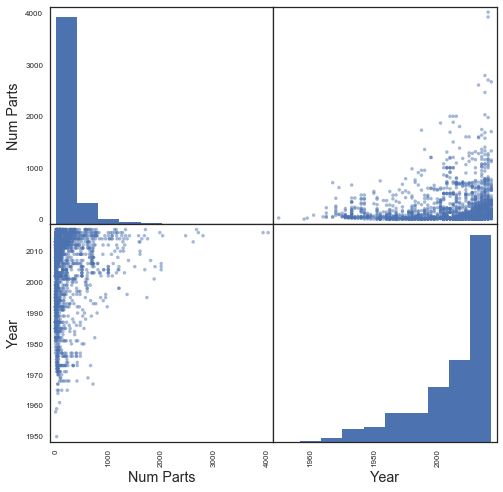

In [5]:
_ = pd.plotting.scatter_matrix(norm_lego[['Theme','Num Parts','Year']], figsize=(8,8))

In [6]:
list(norm_lego.columns.values)

['[No Color]',
 'Aqua',
 'Black',
 'Blue',
 'Blue-Violet',
 'Bright Green',
 'Bright Light Blue',
 'Bright Light Orange',
 'Bright Light Yellow',
 'Bright Pink',
 'Brown',
 'Chrome Antique Brass',
 'Chrome Black',
 'Chrome Blue',
 'Chrome Gold',
 'Chrome Green',
 'Chrome Pink',
 'Chrome Silver',
 'Copper',
 'Dark Azure',
 'Dark Blue',
 'Dark Blue-Violet',
 'Dark Bluish Gray',
 'Dark Brown',
 'Dark Flesh',
 'Dark Gray',
 'Dark Green',
 'Dark Orange',
 'Dark Pink',
 'Dark Purple',
 'Dark Red',
 'Dark Tan',
 'Dark Turquoise',
 'Earth Orange',
 'Fabuland Brown',
 'Flat Dark Gold',
 'Flat Silver',
 'Flesh',
 'Glitter Trans-Clear',
 'Glitter Trans-Dark Pink',
 'Glitter Trans-Light Blue',
 'Glitter Trans-Neon Green',
 'Glitter Trans-Purple',
 'Glow In Dark Opaque',
 'Glow In Dark Trans',
 'Glow in Dark White',
 'Green',
 'Lavender',
 'Light Aqua',
 'Light Blue',
 'Light Bluish Gray',
 'Light Flesh',
 'Light Gray',
 'Light Green',
 'Light Lime',
 'Light Orange',
 'Light Pink',
 'Light Purple',

## Training and Test Splits
Make sure you don't accidentally test on your training data.

## k-Nearest Neighbors

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# Be sure to look at the available parameters on each classifier.
# For example, you might want to experiment with the number of neighbours here. 

#n=4   
#lego_knn = KNeighborsClassifier(n_neighbors=n)
#lego_knn.fit(YOUR_TRAINING_INPUTS, YOUR_TRAINING_LABELS) #TODO — substitute in your own training data

## Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB

In [9]:
#TODO — Train and test

## Decision Trees

In [10]:
from sklearn.tree import DecisionTreeClassifier
from random import randint

In [11]:
lego1 = "Year"
lego2 = "Num Parts"
l_train, l_test, theme_train, theme_test = sk.model_selection.train_test_split(
    lego_frame[[lego1,lego2]],lego_frame['Theme'], test_size=0.4, random_state=0)
dtree = DecisionTreeClassifier()
treeFit = dtree.fit(l_train, theme_train)
lego_predictions_test = dtree.predict(l_test)
motor = np.array([[1997, 439]])
p = treeFit.predict(motor)
p  # Expected 'Technic"

array(['Technic'], dtype=object)

In [12]:
accuracy = skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_predictions_test)
accuracy

0.4497907949790795

In [13]:
precision =  skm.precision_score(y_true=theme_test,
                    y_pred=lego_predictions_test,
                    average='weighted')
precision 

0.4458132218293639

In [14]:
recall = skm.recall_score(y_true=theme_test,
                 y_pred=lego_predictions_test,
                 average='weighted') 
recall 

0.4497907949790795

In [15]:
F1 = skm.f1_score(y_true=theme_test,
             y_pred=lego_predictions_test,
             average='weighted')
F1

0.4456871990092766

In [16]:
lego_cfmat = skm.confusion_matrix(
    y_true=theme_test,
    y_pred=lego_predictions_test,)
lego_cfmat

array([[ 26,   6,   1,  14,   3,   2,   1,   2,   0,  17],
       [ 11,  60,   1,  12,   4,   1,   3,   4,   3,   4],
       [  1,   5,  64,   0,   3,   6,  10,   4,   8,   4],
       [ 13,  16,   2,  19,   3,   2,   2,   1,   2,  11],
       [  4,   8,   7,   4,  47,  11,   7,   4,   5,   7],
       [  3,   4,  15,   3,   6,  26,  10,   6,  12,   4],
       [  1,   0,   7,   0,   6,  15,  43,   7,  16,   3],
       [  2,   1,   6,   2,  15,  13,  15,  20,  10,   2],
       [  0,   4,  13,   0,   6,   7,  13,   5,  16,   3],
       [ 10,  14,   1,   4,   4,   7,   4,   3,   5, 109]], dtype=int64)

Text(0.5,1,'Confusion Matrix')

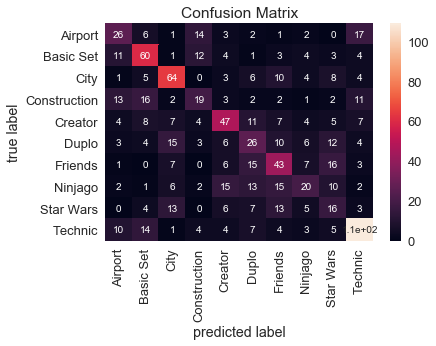

In [17]:
sns.heatmap(lego_cfmat, 
            xticklabels=dtree.classes_,
            yticklabels=dtree.classes_,
            annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')


#### Drawing a Decision Tree
Rendering decision trees requires the graphviz package. You can install it from the terminal or command line using:
> conda install python-graphviz

In [18]:
import graphviz 
graph_data = sk.tree.export_graphviz(YOUR_CLASSIFIER, out_file=None,
                         feature_names=YOUR_FEATURE_NAMES,  
                         class_names=YOUR_CLASS_NAMES,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(graph_data) 
graph

# Or save out to a file using this command:
# graph.render("decision_tree") 

ModuleNotFoundError: No module named 'graphviz'

## Random Forest

In [ ]:
# Generate test and training sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


First, to avoid overfitting, I went about fitting the classifier over all of the non-unique, non-float columns. Then I looked at the feature importances. Year affects the weight for classifying more than others, followed by 'Num Parts'

In [ ]:
#Combine all the non-float columns
combined_cols = pd.Series(color_cols).append(pd.Series(other_cols)).values

#Split Data
RandomTrees_Feat_Train, RandomTrees_Feat_Test,RandomTrees_Feat_Theme_Train, RandomTrees_Feat_Theme_Test = train_test_split(norm_lego[combined_cols], norm_lego['Theme'], test_size=0.4, random_state=0)

#Fit over All the columns.
randomclassifier = RandomForestClassifier(n_estimators=250, random_state=0)
#Train over training data
randomclassifier = randomclassifier.fit(RandomTrees_Feat_Train,RandomTrees_Feat_Theme_Train)
model = randomclassifier
#Perform predictions with the test data.
randomtrees_predictions_test = model.predict(RandomTrees_Feat_Test)

#Zipped up the list of feature importances with labels.
featureImportance = list(zip(RandomTrees_Feat_Train, model.feature_importances_))
#Sort from greatest to least
sorted_featureImp = sorted(featureImportance, key=lambda x: x[1],reverse=True)
df_featureImp = pd.DataFrame(sorted_featureImp)

#Took the top 20 and set index for labelling in chart 
top20_features = df_featureImp.head(20)
top20_features = top20_features.set_index(0)

#Plot data on chart
top20_features.plot(kind='bar',legend=False,figsize=(5,5))
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

print(top20_features)


I decided to play with the features that had weight importance > 0.05. 
Next I looked at correlations just to potentially ignore certain features if there's a pair strongly correlated. As show below, no such pair exists.

In [ ]:
pick6 = ['Year','Num Parts','Yellow','White','Black','Red']
pick2 = ['Year','Num Parts']
norm_lego[pick6].corr()


Now suppose we take these values and fit the random trees over these particular columns. 

In [ ]:
RandomTrees_YearPart_Train, RandomTrees_YearPart_Test,RandomTrees_Theme_Train, RandomTrees_Theme_Test = train_test_split(norm_lego[pick6], 
                                                                                                                         norm_lego['Theme'], test_size=0.4, random_state=0)
#Columns selected = ['Year','Num Parts','Yellow','White','Black','Red']
randomclassifier = RandomForestClassifier(n_estimators=250, random_state=0,bootstrap=True)
randomclassifier = randomclassifier.fit(RandomTrees_YearPart_Train,RandomTrees_Theme_Train)
model = randomclassifier
randomtrees_predictions_test = model.predict(RandomTrees_YearPart_Test)

#How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix.
#(Remember, don’t test on your training data!)

rand_acc = skm.accuracy_score(y_true=RandomTrees_Theme_Test,
                   y_pred=randomtrees_predictions_test)

rand_prec =  skm.precision_score(y_true=RandomTrees_Theme_Test,
                    y_pred=randomtrees_predictions_test,
                    average='weighted')

rand_rec = skm.recall_score(y_true=RandomTrees_Theme_Test,
                 y_pred=randomtrees_predictions_test,
                 average='weighted') 

rand_F1 = skm.f1_score(y_true=RandomTrees_Theme_Test,
             y_pred=randomtrees_predictions_test,
             average='weighted')

print("Accuracy: "+str(rand_acc))
print("Precision: "+str(rand_prec))
print("Recall: "+str(rand_rec))
print("F1 Score: "+str(rand_F1))


Below I just take the first two columns 'Year' and 'Num Parts' to compare. These two have bigger differences to the other values.

In [ ]:
RandomTrees_YearPart_Train, RandomTrees_YearPart_Test,RandomTrees_Theme_Train, RandomTrees_Theme_Test = train_test_split(norm_lego[pick2], 
                                                                                                                         norm_lego['Theme'], test_size=0.4, random_state=0)
#Selected Features: 'Year' and 'Num Parts'
randomclassifier = RandomForestClassifier(n_estimators=250, random_state=0,bootstrap=True)
randomclassifier = randomclassifier.fit(RandomTrees_YearPart_Train,RandomTrees_Theme_Train)
model = randomclassifier
randomtrees_predictions_yearpart_test = model.predict(RandomTrees_YearPart_Test)

#How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix.
#(Remember, don’t test on your training data!)

rand_acc = skm.accuracy_score(y_true=RandomTrees_Theme_Test,
                   y_pred=randomtrees_predictions_yearpart_test)
rand_prec =  skm.precision_score(y_true=RandomTrees_Theme_Test,
                    y_pred=randomtrees_predictions_yearpart_test,
                    average='weighted')

rand_rec = skm.recall_score(y_true=RandomTrees_Theme_Test,
                 y_pred=randomtrees_predictions_yearpart_test,
                 average='weighted') 

rand_F1 = skm.f1_score(y_true=RandomTrees_Theme_Test,
             y_pred=randomtrees_predictions_yearpart_test,
             average='weighted')

print("Accuracy: "+str(rand_acc))
print("Precision: "+str(rand_prec))
print("Recall: "+str(rand_rec))
print("F1 Score: "+str(rand_F1))


This results in massively different values arise, suggesting to take more columns rather than less. However, that is probably because of overfitting. After all, the 0.05 threshold is arbitrary as there is not as much of a gap from >0.05 values and >0.04 values compared to the gap of >0.07 values. Thsu, we'll stick with the latter pick 2 select 'Year' and 'Num Parts'

In [ ]:
rand_lego_cfm = skm.confusion_matrix(
    y_true=RandomTrees_Theme_Test,
    y_pred=randomtrees_predictions_yearpart_test)
rand_lego_cfm




In [ ]:
sns.heatmap(rand_lego_cfm, 
            xticklabels=randomclassifier.classes_,
            yticklabels=randomclassifier.classes_,
            annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')


This classifier has a problem with Identifying the 'Construction set' from 'Basic Set' and to a lesser extent from 'Airport' & 'Technic'. 'Star Wars' also causes confusion as does 'Duplo'. There is also problem is identifying the 'Ninjago' Theme from the 'Friends' Theme.

It is good at identifying 'Technic', 'Basic Set' and 'City'. I tried to find some reason by looking at commonalities in columns selected between these themes.

In [ ]:

RandTree_Valid_df = norm_lego[['Num Parts','Theme']]
num_parts_theme_sum = RandTree_Valid_df.groupby(['Theme']).sum()
num_parts_theme_mean = RandTree_Valid_df.groupby(['Theme']).mean()
num_parts_theme_mode = RandTree_Valid_df.groupby(['Theme']).agg(lambda x:x.value_counts().index[0])
fig1 = plt.figure(figsize=[5,5])
fig, axs = plt.subplots(figsize=[15,5], ncols=3)
ax1, ax2,ax3 = axs
print("Yellow marks strong classification/less confusion. Red marks weak classification/more confusion")

#Plot Charts
num_parts_theme_sum.plot(kind='bar',ax=ax1,legend=False,title='Sum of Parts')
num_parts_theme_mean.plot(kind='bar',ax=ax2,legend=False, title='Average # Parts')
num_parts_theme_mode.plot(kind='bar',ax=ax3,legend=False, title='Most often occurence # Parts')

#Highlight bars of interest.
highlight = 'Construction'
pos = num_parts_theme_sum.index.get_loc(highlight)
ax1.patches[pos].set_facecolor('#aa3333')
ax2.patches[pos].set_facecolor('#aa3333')
ax3.patches[pos].set_facecolor('#aa3333')

highlight = 'Star Wars'
pos = num_parts_theme_sum.index.get_loc(highlight)
ax1.patches[pos].set_facecolor('#aa3333')
ax2.patches[pos].set_facecolor('#aa3333')
ax3.patches[pos].set_facecolor('#aa3333')


highlight = 'Ninjago'
pos = num_parts_theme_sum.index.get_loc(highlight)
ax1.patches[pos].set_facecolor('#aa3333')
ax2.patches[pos].set_facecolor('#aa3333')
ax3.patches[pos].set_facecolor('#aa3333')

highlight='Basic Set'
pos = num_parts_theme_sum.index.get_loc(highlight)
ax1.patches[pos].set_facecolor('#fffd9b')
ax2.patches[pos].set_facecolor('#fffd9b')
ax3.patches[pos].set_facecolor('#fffd9b')

highlight='Technic'
pos = num_parts_theme_sum.index.get_loc(highlight)
ax1.patches[pos].set_facecolor('#fffd9b')
ax2.patches[pos].set_facecolor('#fffd9b')
ax3.patches[pos].set_facecolor('#fffd9b')


highlight='City'
pos = num_parts_theme_sum.index.get_loc(highlight)
ax1.patches[pos].set_facecolor('#fffd9b')
ax2.patches[pos].set_facecolor('#fffd9b')
ax3.patches[pos].set_facecolor('#fffd9b')



plt.show()

RandTree_Valid_df_yt = norm_lego[['Year','Theme']]

#Observed distribution. Unsure if I can make any claims to similarities between them.
#_ = RandTree_Valid_df_yt.hist(layout=(2,5), figsize=(10,10), by='Theme')

year_theme = RandTree_Valid_df_yt.groupby(['Theme']).agg(lambda x:x.value_counts().index[0])
year_theme.sort_values('Year')

Looking more at the above values 'City' and 'Duplo' have similar # of parts and the same most common year for that theme so that might be where the confusion arises. 'Basic Set' is quite uinque in its most common year and the size of its set which I guess made it easier for the classifier to identify. 'Ninjago' & 'Friends' though don't have that surface level closeness in these features so it's a little wierd about the confusion. 'Construction' is average in the Num_Parts despite a different common year. 'Star Wars' shares quite a bunch of similarities with other themes. 

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
hw_train, hw_test, theme_train, theme_test = sk.model_selection.train_test_split(norm_lego[color_cols],norm_lego['Theme'], test_size=0.4, random_state=0)
lego_test = MLPClassifier(hidden_layer_sizes=(200, 200), solver="lbfgs", learning_rate="adaptive", max_iter=400).fit(hw_train, theme_train)
lego_predictions = lego_test.predict(hw_test)

print("Accuracy: " + str(skm.accuracy_score(y_true=theme_test, y_pred=lego_predictions)))
print("Precision: " + str(skm.precision_score(y_true=theme_test, y_pred=lego_predictions, average="weighted")))
print("Recall: " + str(skm.recall_score(y_true=theme_test, y_pred=lego_predictions, average="weighted")))
print("F1 Score: " + str(skm.f1_score(y_true=theme_test, y_pred=lego_predictions, average="weighted")))

I changed the solver from "adam" to "lbfgs" because the dataset was too small in order to converge quickly. However, after changing to the "lbfgs" solver, it was able to converage and produced better results.

I also increased the maximum number of iterations, which slightly improved accuracy and the F1 score, but not by much.

Lastly, I increased the hidden layer sizes in order to get more stable results. Before changing this, my F1 score would vary from approximately 0.69 to 0.71, whereas with the changed values it remains at around 0.705 to 0.71.

In [ ]:
lego_neigh_cfmat = skm.confusion_matrix(y_true=theme_test, y_pred=lego_predictions,)
sns.heatmap(lego_neigh_cfmat, xticklabels=lego_test.classes_, yticklabels=lego_test.classes_, annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')

It seems that the classifier was relatively accurate about most things, save for when trying to identify the difference between the themes "Creator" and "City". The classifier was good at identifying which sets fit within the "Basic Set Theme". After doing some searches online, it seemed that Creator was a much broader spectrum than something more specific such at Star Wars, which had specific colors to help in identifying the set. The neurnal net was able to draw conclusions to more specific sets by using unique pieces, but struggled to identify sets that had a broader coverage in terms of colors. 